In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os,sys
sys.path.append(os.path.join(os.getcwd(), ".."))
import tensorflow as tf

from superpoint.settings import EXPER_PATH
import superpoint.evaluations.detector_evaluation as ev
from utils import plot_imgs
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [11]:
exp = [
    'mp_synth-v6_photo-hom-aug_hp-v-repeat',
    'mp_synth-v6_photo-hom-aug_ha2-100-0_hp-v-repeat']
names = ['MagicPoint', 'MagicPoint after 2 adaptations']
thresh = 0.001
num_points = 300

In [12]:
def draw_keypoints(img, corners, color, radius=3, s = 3):
    img = np.repeat(cv2.resize(img, None, fx=s, fy=s)[..., np.newaxis], 3, -1)
    for c in np.stack(corners).T:
        cv2.circle(img, tuple(s*np.flip(c, 0)), radius, color, thickness=-1)
    return img

In [13]:
def compute_repeatability(data, keep_k_points=300,
                          distance_thresh=3, verbose=False):
    """
    Compute the repeatability. data must contain the prediction
    on 2 images, an original image and a warped version of it, plus the homography
    linking the 2 images.
    """
    def warp_keypoints(keypoints, H):
        num_points = keypoints.shape[0]
        homogeneous_points = np.concatenate([keypoints, np.ones((num_points, 1))],
                                            axis=1)
        warped_points = np.dot(homogeneous_points, np.transpose(H))
        return warped_points[:, :2] / warped_points[:, 2:]

    def filter_keypoints(points, shape):
        """ Keep only the points whose coordinates are
        inside the dimensions of shape. """
        mask = (points[:, 0] >= 0) & (points[:, 0] < shape[0]) &\
               (points[:, 1] >= 0) & (points[:, 1] < shape[1])
        return points[mask, :]

    def keep_true_keypoints(points, H, shape):
        """ Keep only the points whose warped coordinates by H
        are still inside shape.. """
        warped_points = warp_keypoints(points[:, [1, 0]], H)
        warped_points[:, [0, 1]] = warped_points[:, [1, 0]]
        mask = (warped_points[:, 0] >= 0) & (warped_points[:, 0] < shape[0]) &\
               (warped_points[:, 1] >= 0) & (warped_points[:, 1] < shape[1])
        return points[mask, :]

    def select_k_best(points, k):
        """ Select the k most probable points (and strip their proba).
        points has shape (num_points, 3) where the last coordinate is the proba. """
        sorted_prob = points[points[:, 2].argsort(), :2]
        start = min(k, points.shape[0])
        return sorted_prob[-start:, :]

    shape = data['warped_prob'].shape
    H = data['homography']

    # Filter out predictions
    keypoints = np.where(data['prob'] > 0)
    prob = data['prob'][keypoints[0], keypoints[1]]
    keypoints = np.stack([keypoints[0], keypoints[1]], axis=-1)
    warped_keypoints = np.where(data['warped_prob'] > 0)
    warped_prob = data['warped_prob'][warped_keypoints[0], warped_keypoints[1]]
    warped_keypoints = np.stack([warped_keypoints[0],
                                 warped_keypoints[1],
                                 warped_prob], axis=-1)
    warped_keypoints = keep_true_keypoints(warped_keypoints, np.linalg.inv(H),
                                           data['prob'].shape)

    # Warp the original keypoints with the true homography
    true_warped_keypoints = warp_keypoints(keypoints[:, [1, 0]], H)
    true_warped_keypoints = np.stack([true_warped_keypoints[:, 1],
                                     true_warped_keypoints[:, 0],
                                     prob], axis=-1)
    true_warped_keypoints = filter_keypoints(true_warped_keypoints, shape)

    # Keep only the keep_k_points best predictions
    warped_keypoints = select_k_best(warped_keypoints, keep_k_points)
    true_warped_keypoints = select_k_best(true_warped_keypoints, keep_k_points)

    # Compute the repeatability
    N1 = true_warped_keypoints.shape[0]
    N2 = warped_keypoints.shape[0]
    true_warped_keypoints = np.expand_dims(true_warped_keypoints, 1)
    warped_keypoints = np.expand_dims(warped_keypoints, 0)
     # shapes are broadcasted to N1 x N2 x 2:
    norm = np.linalg.norm(true_warped_keypoints - warped_keypoints,
                          ord=None, axis=2)
    count1 = 0
    count2 = 0
    if N2 != 0:
        min1 = np.min(norm, axis=1)
        count1 = np.sum(min1 <= distance_thresh)
    if N1 != 0:
        min2 = np.min(norm, axis=0)
        count2 = np.sum(min2 <= distance_thresh)
    repeatability = 0.
    if N1 + N2 > 0:
        repeatability = (count1 + count2) / (N1 + N2)

    if verbose:
        print("Number of points in the first image: " + str(N1))
        print("Number of points in the second image: " + str(N2))
    return N1, N2, repeatability

In [14]:
nb_exp = len(exp)
N1s = [[] for j in range(nb_exp)]
N2s = [[] for j in range(nb_exp)]
rep = [[] for j in range(nb_exp)]
nb_img = 295
for i in range(nb_img):
    for e in range(nb_exp):
        path = Path(EXPER_PATH, "outputs", exp[e], str(i) + ".npz")
        d = np.load(path)
        N1, N2, repeatability = compute_repeatability(d, keep_k_points=300, distance_thresh=3)
        N1s[e].append(N1)
        N2s[e].append(N2)
        rep[e].append(repeatability)

for e in range(nb_exp):
    print("> " + exp[e] + ":")
    print("Average N1 = " + str(np.mean(N1s[e])))
    less = np.sum(np.array(N1s[e]) <= 150)
    more = np.sum(np.array(N1s[e]) > 295)
    mid = nb_img - less - more
    print("Less than 150 N1: " + str(less / nb_img) + "%")
    print("More than 295 N1: " + str(more / nb_img) + "%")
    print("Between 150 and 295 N1: " + str(mid / nb_img) + "%\n")
    print("Average N2 = " + str(np.mean(N2s[e])))
    less = np.sum(np.array(N2s[e]) <= 150)
    more = np.sum(np.array(N2s[e]) > 295)
    mid = nb_img - less - more
    print("Less than 150 N2: " + str(less / nb_img) + "%")
    print("More than 295 N2: " + str(more / nb_img) + "%")
    print("Between 150 and 295 N2: " + str(mid / nb_img) + "%\n")
    print("repeatability = " + str(np.mean(rep[e])) + "\n\n")

> mp_synth-v6_photo-hom-aug_hp-v-repeat:
Average N1 = 293.8033898305085
Less than 150 N1: 0.01694915254237288%
More than 295 N1: 0.9559322033898305%
Between 150 and 295 N1: 0.02711864406779661%

Average N2 = 288.2542372881356
Less than 150 N2: 0.03389830508474576%
More than 295 N2: 0.9084745762711864%
Between 150 and 295 N2: 0.0576271186440678%

repeatability = 0.3715630260055751


> mp_synth-v6_photo-hom-aug_ha2-100-0_hp-v-repeat:
Average N1 = 298.6033898305085
Less than 150 N1: 0.0%
More than 295 N1: 0.9830508474576272%
Between 150 and 295 N1: 0.01694915254237288%

Average N2 = 290.3050847457627
Less than 150 N2: 0.030508474576271188%
More than 295 N2: 0.9152542372881356%
Between 150 and 295 N2: 0.05423728813559322%

repeatability = 0.4186337840230402




Number of points in the first image: 300
Number of points in the second image: 300
> 35: rep = 0.51
Number of points in the first image: 300
Number of points in the second image: 300
> 35: rep = 0.575
Number of points in the first image: 300
Number of points in the second image: 300
> 36: rep = 0.39666666666666667
Number of points in the first image: 300
Number of points in the second image: 300
> 36: rep = 0.4116666666666667
Number of points in the first image: 300
Number of points in the second image: 300
> 37: rep = 0.33166666666666667
Number of points in the first image: 300
Number of points in the second image: 300
> 37: rep = 0.36666666666666664
Number of points in the first image: 300
Number of points in the second image: 300
> 38: rep = 0.27166666666666667
Number of points in the first image: 300
Number of points in the second image: 300
> 38: rep = 0.2783333333333333
Number of points in the first image: 300
Number of points in the second image: 300
> 39: rep = 0.3
Number of po

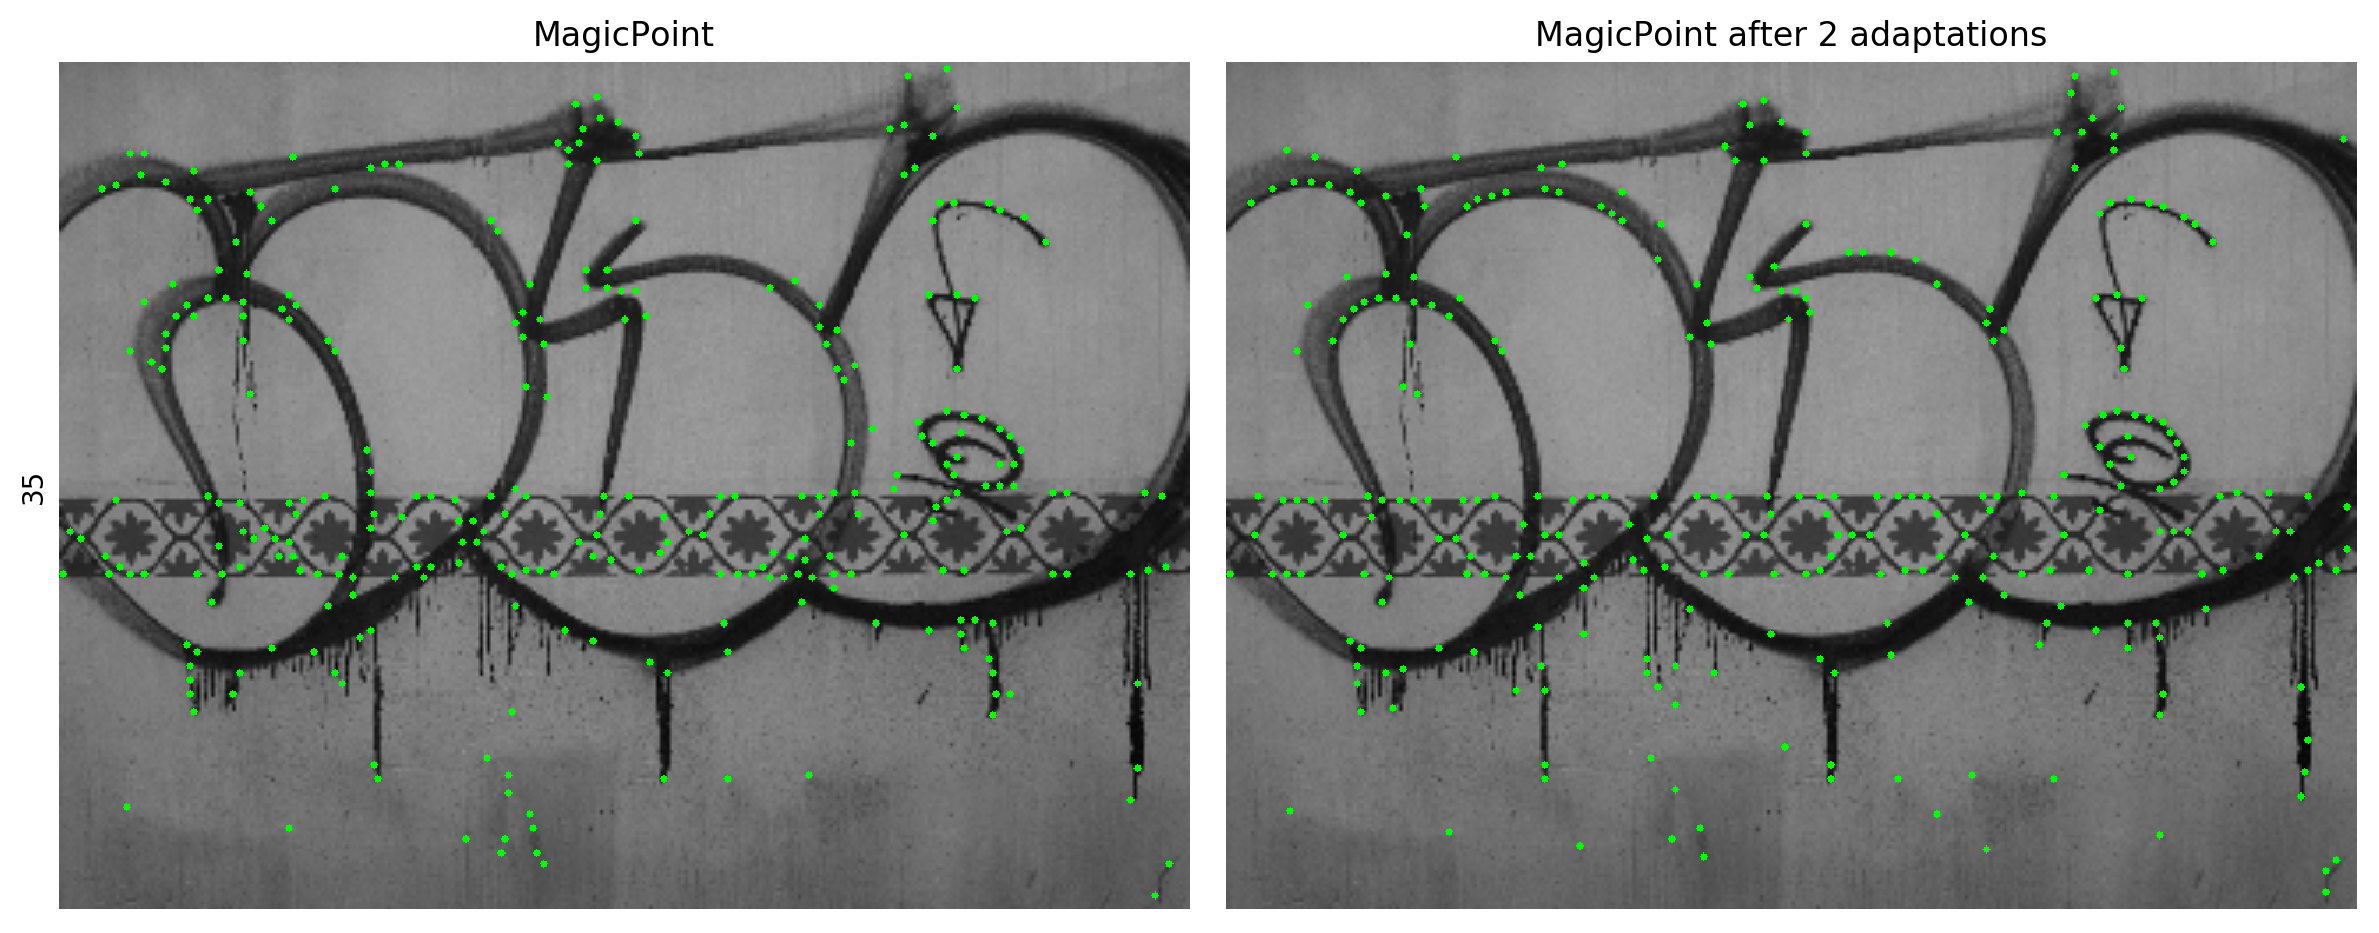

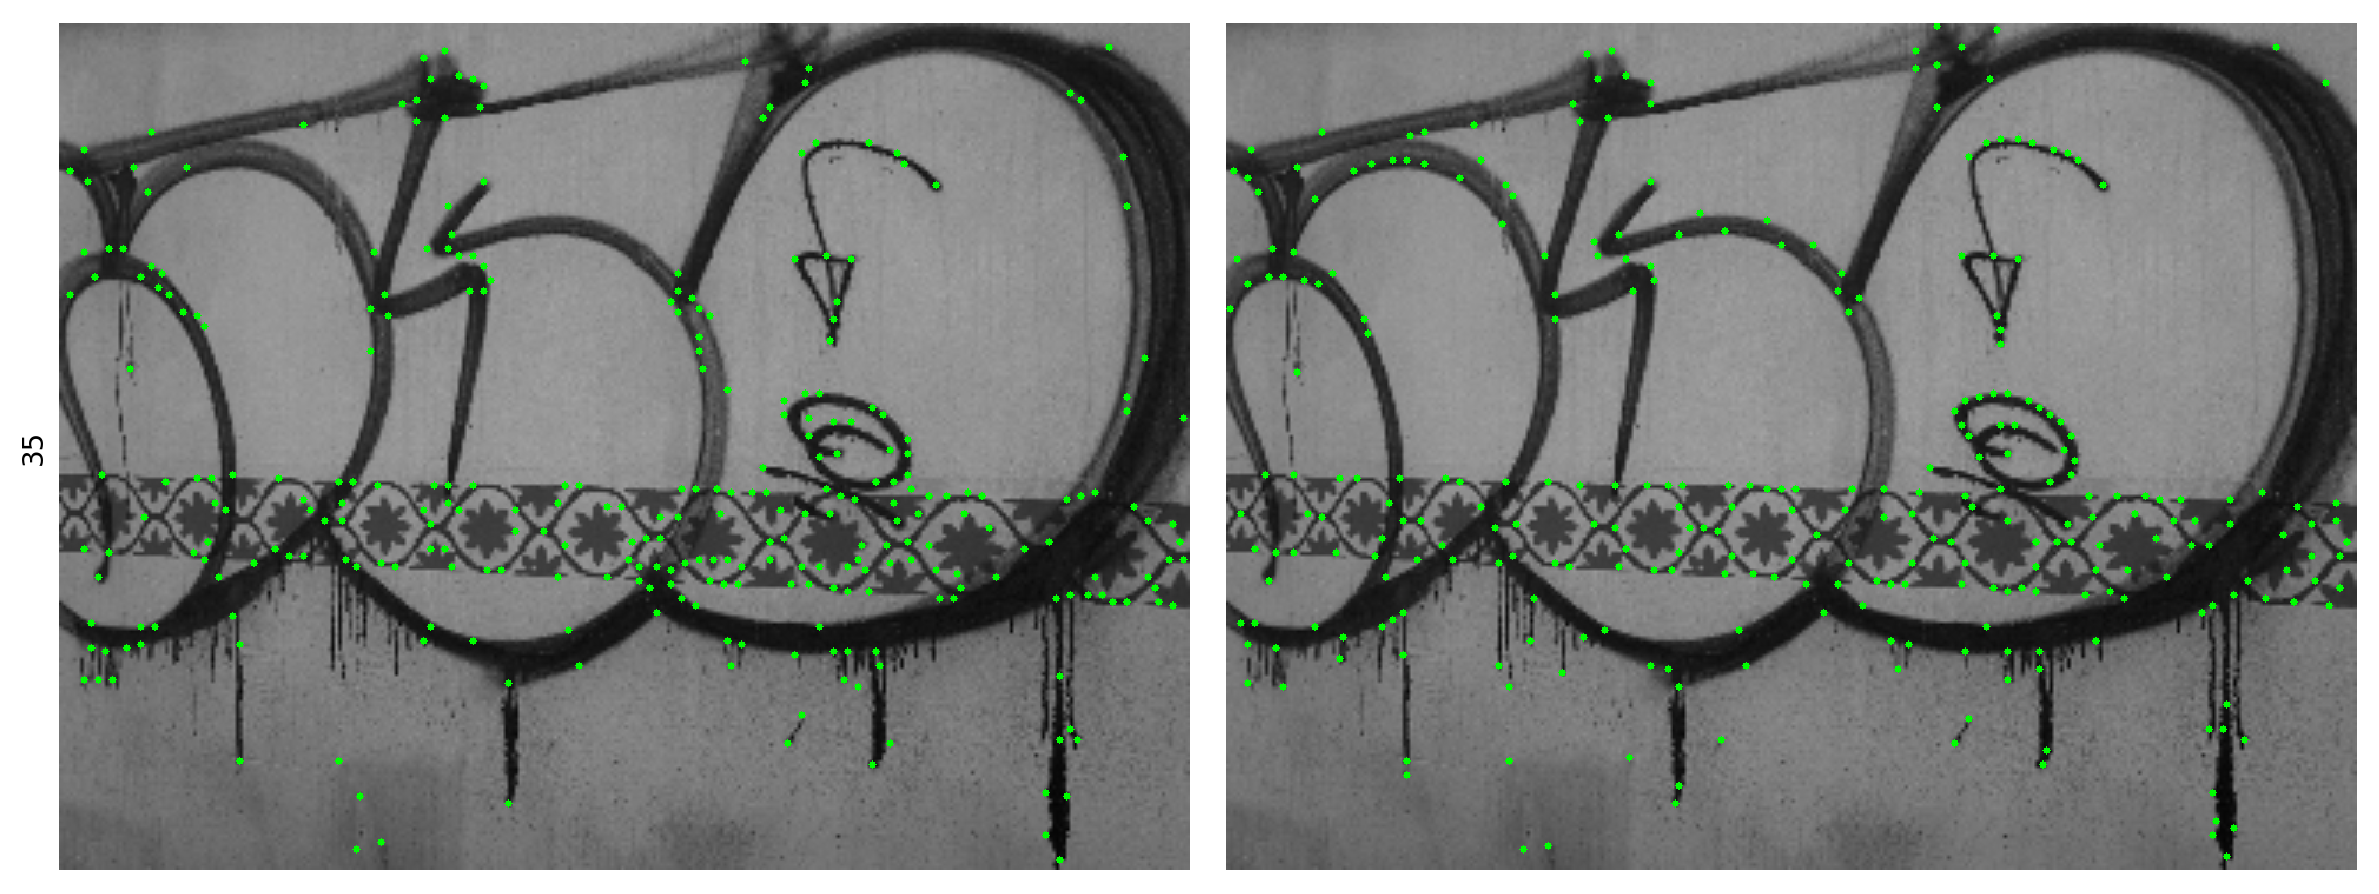

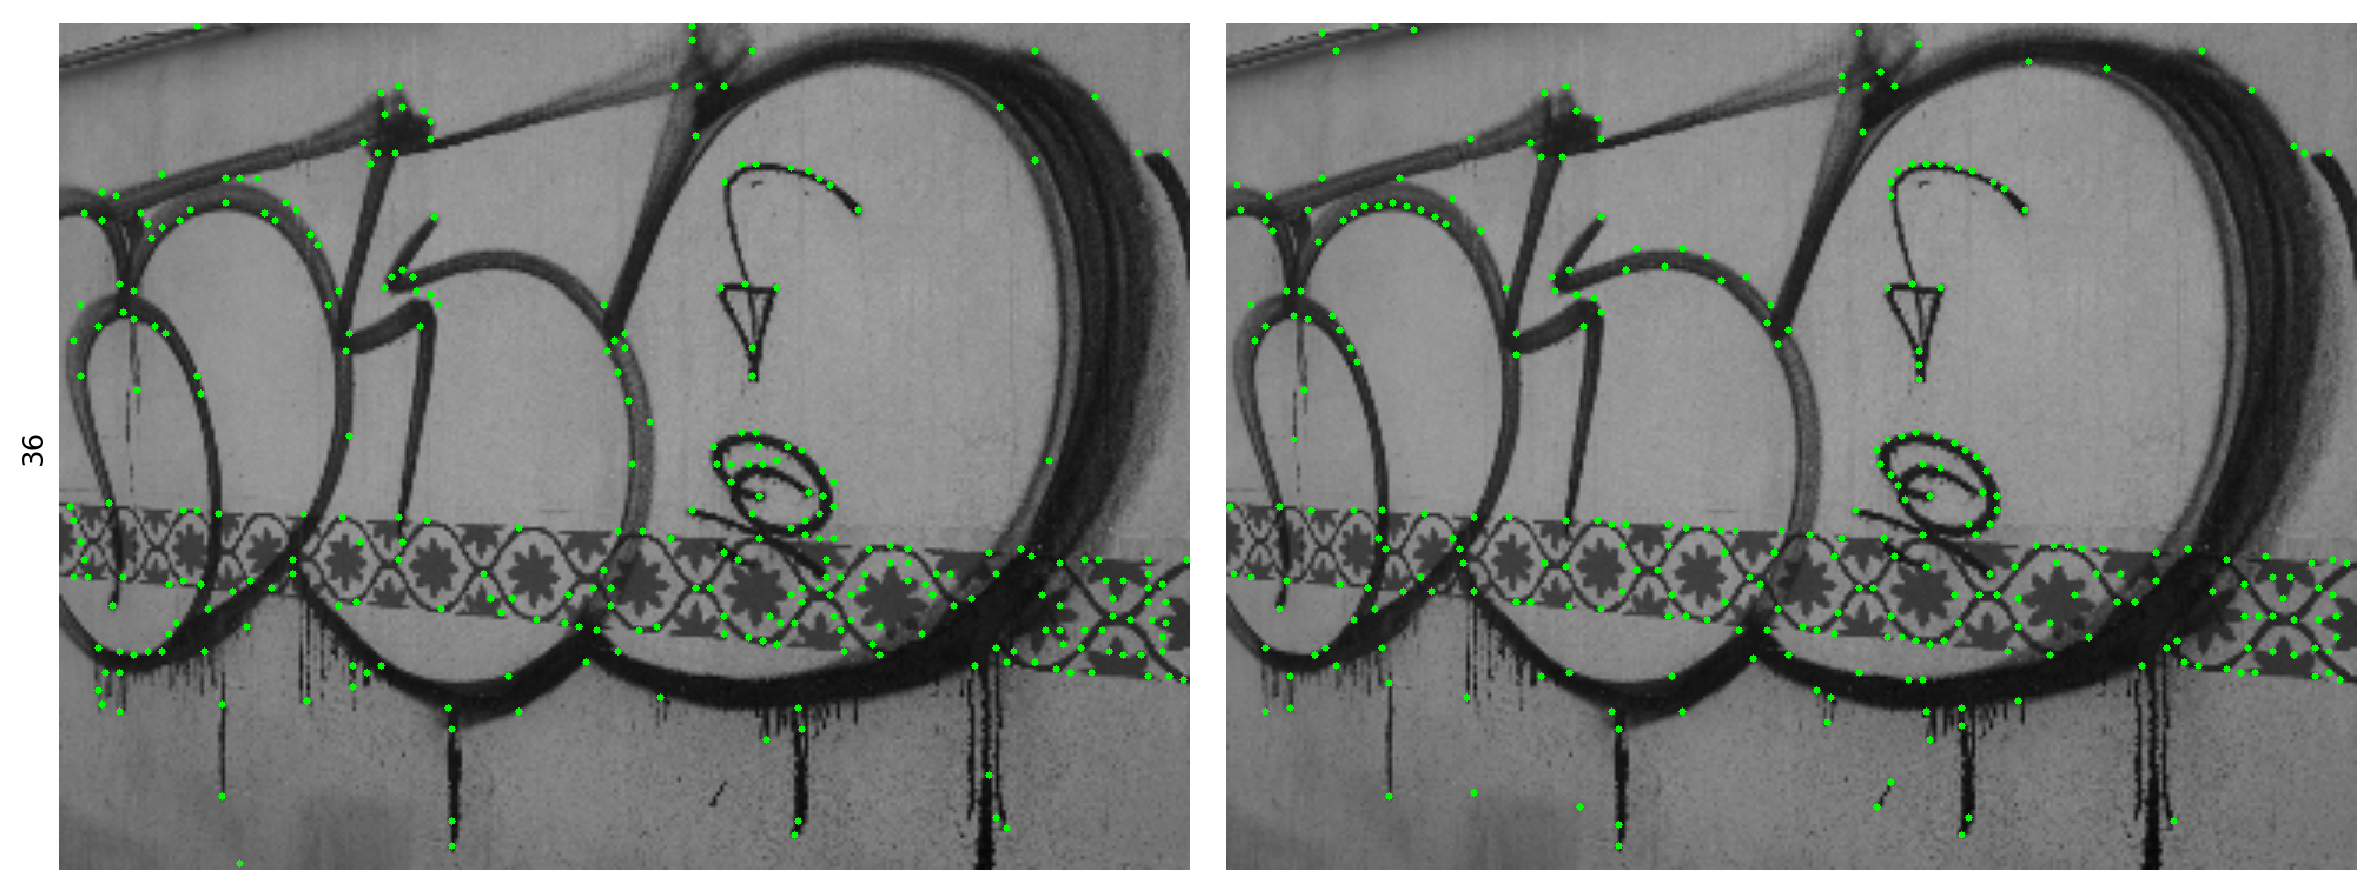

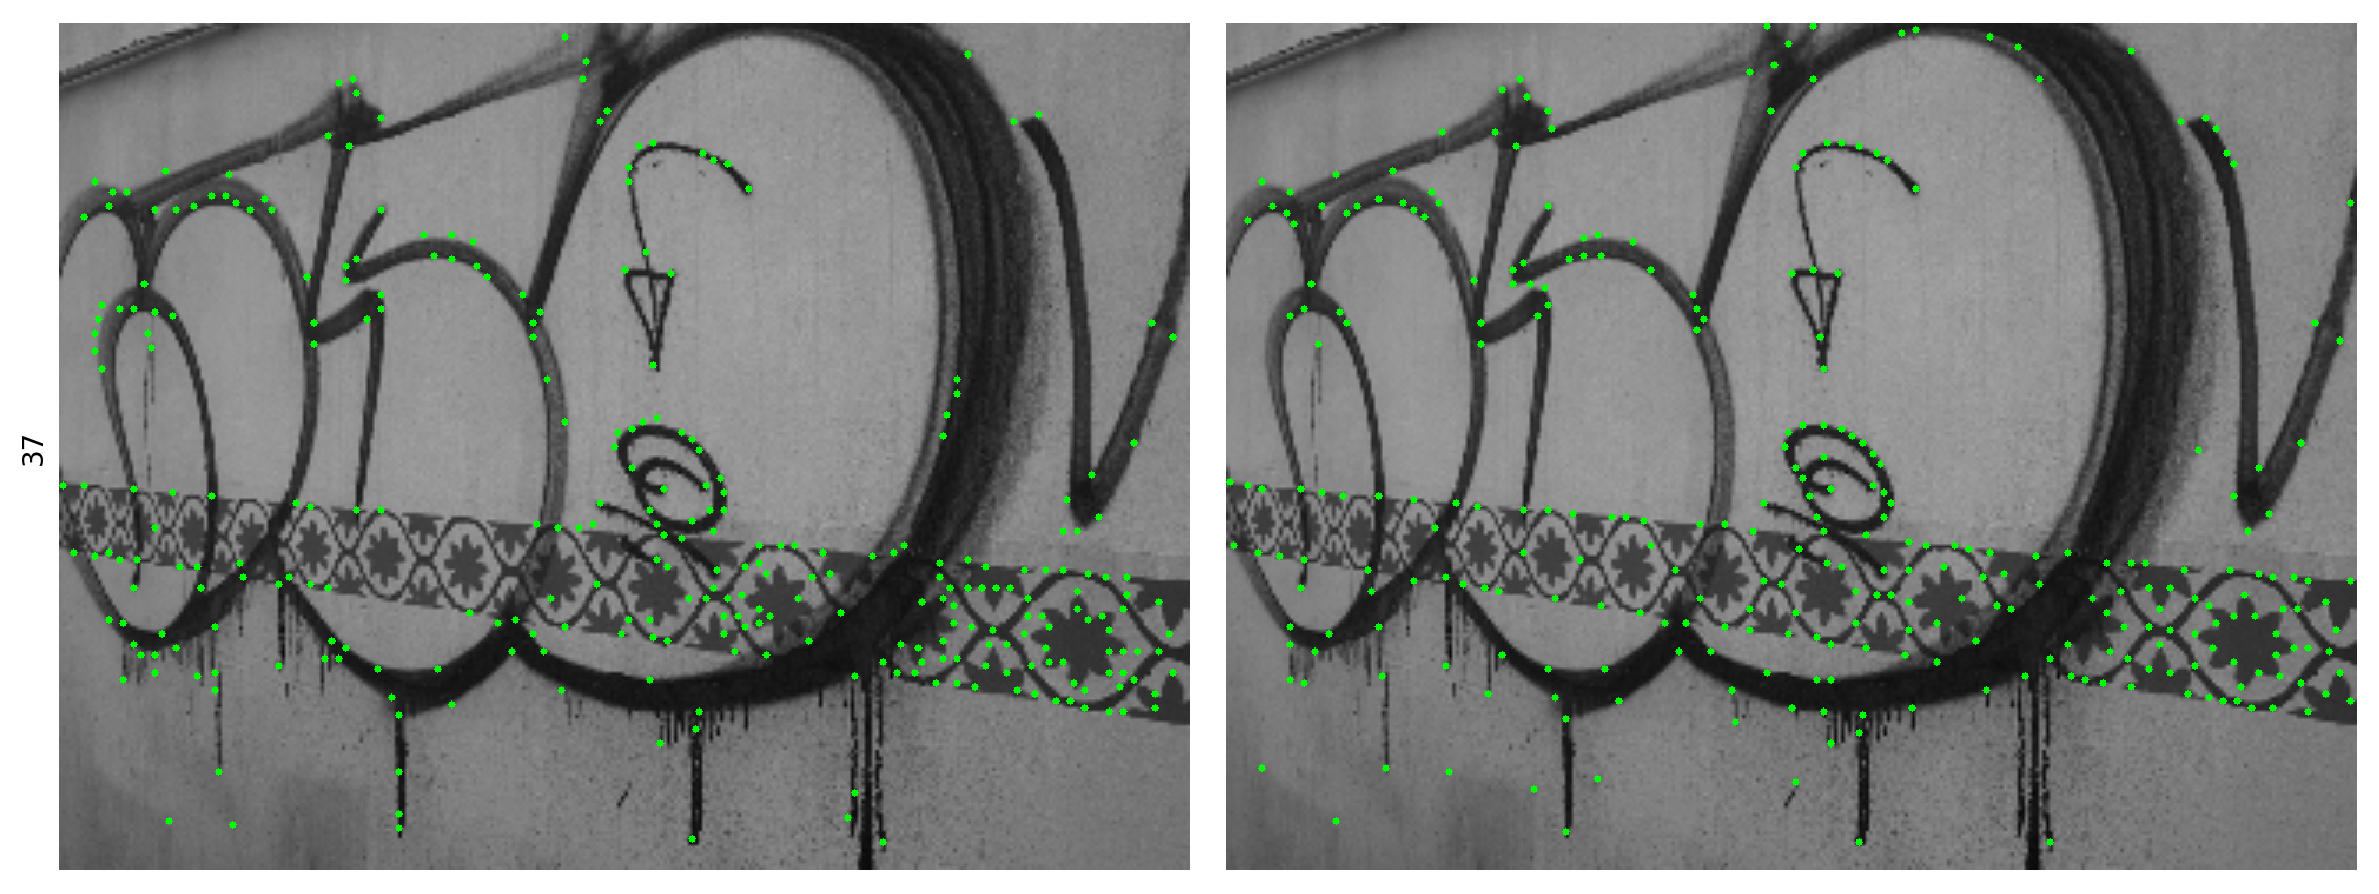

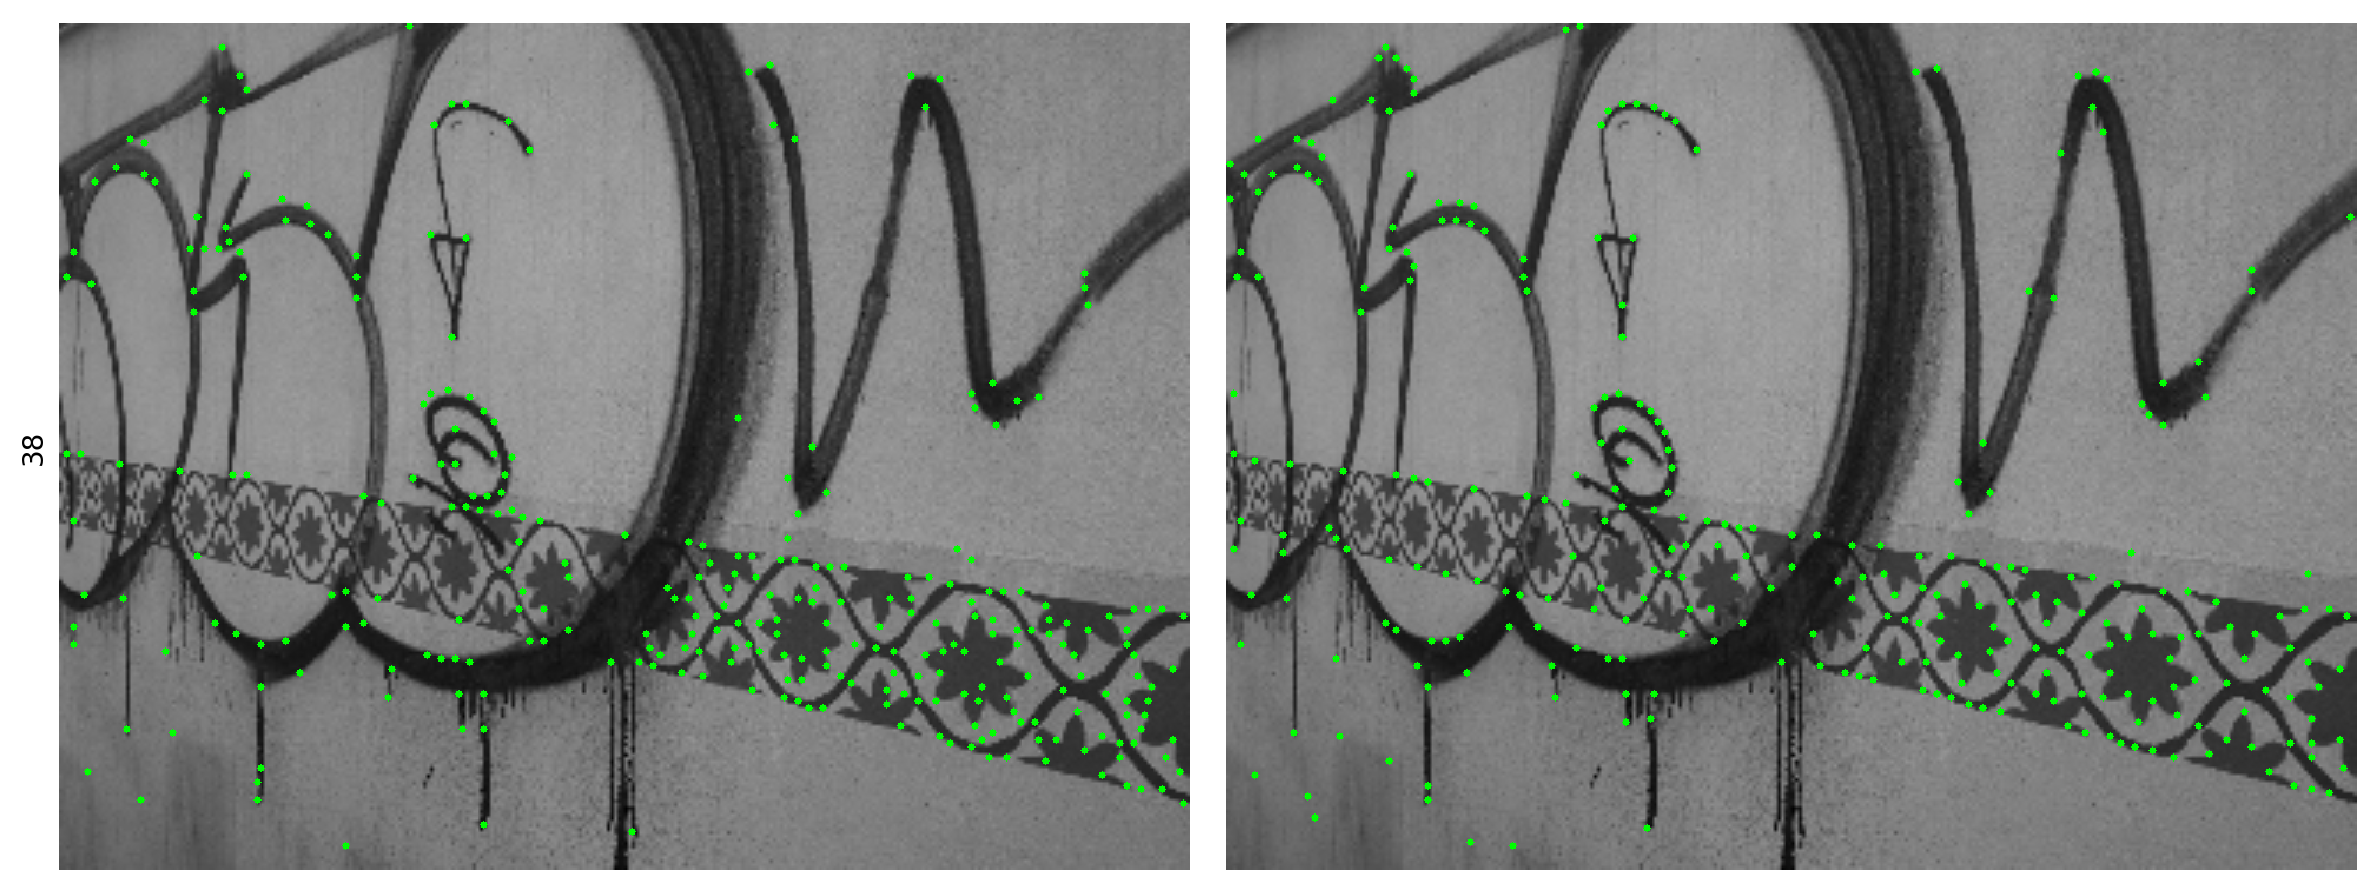

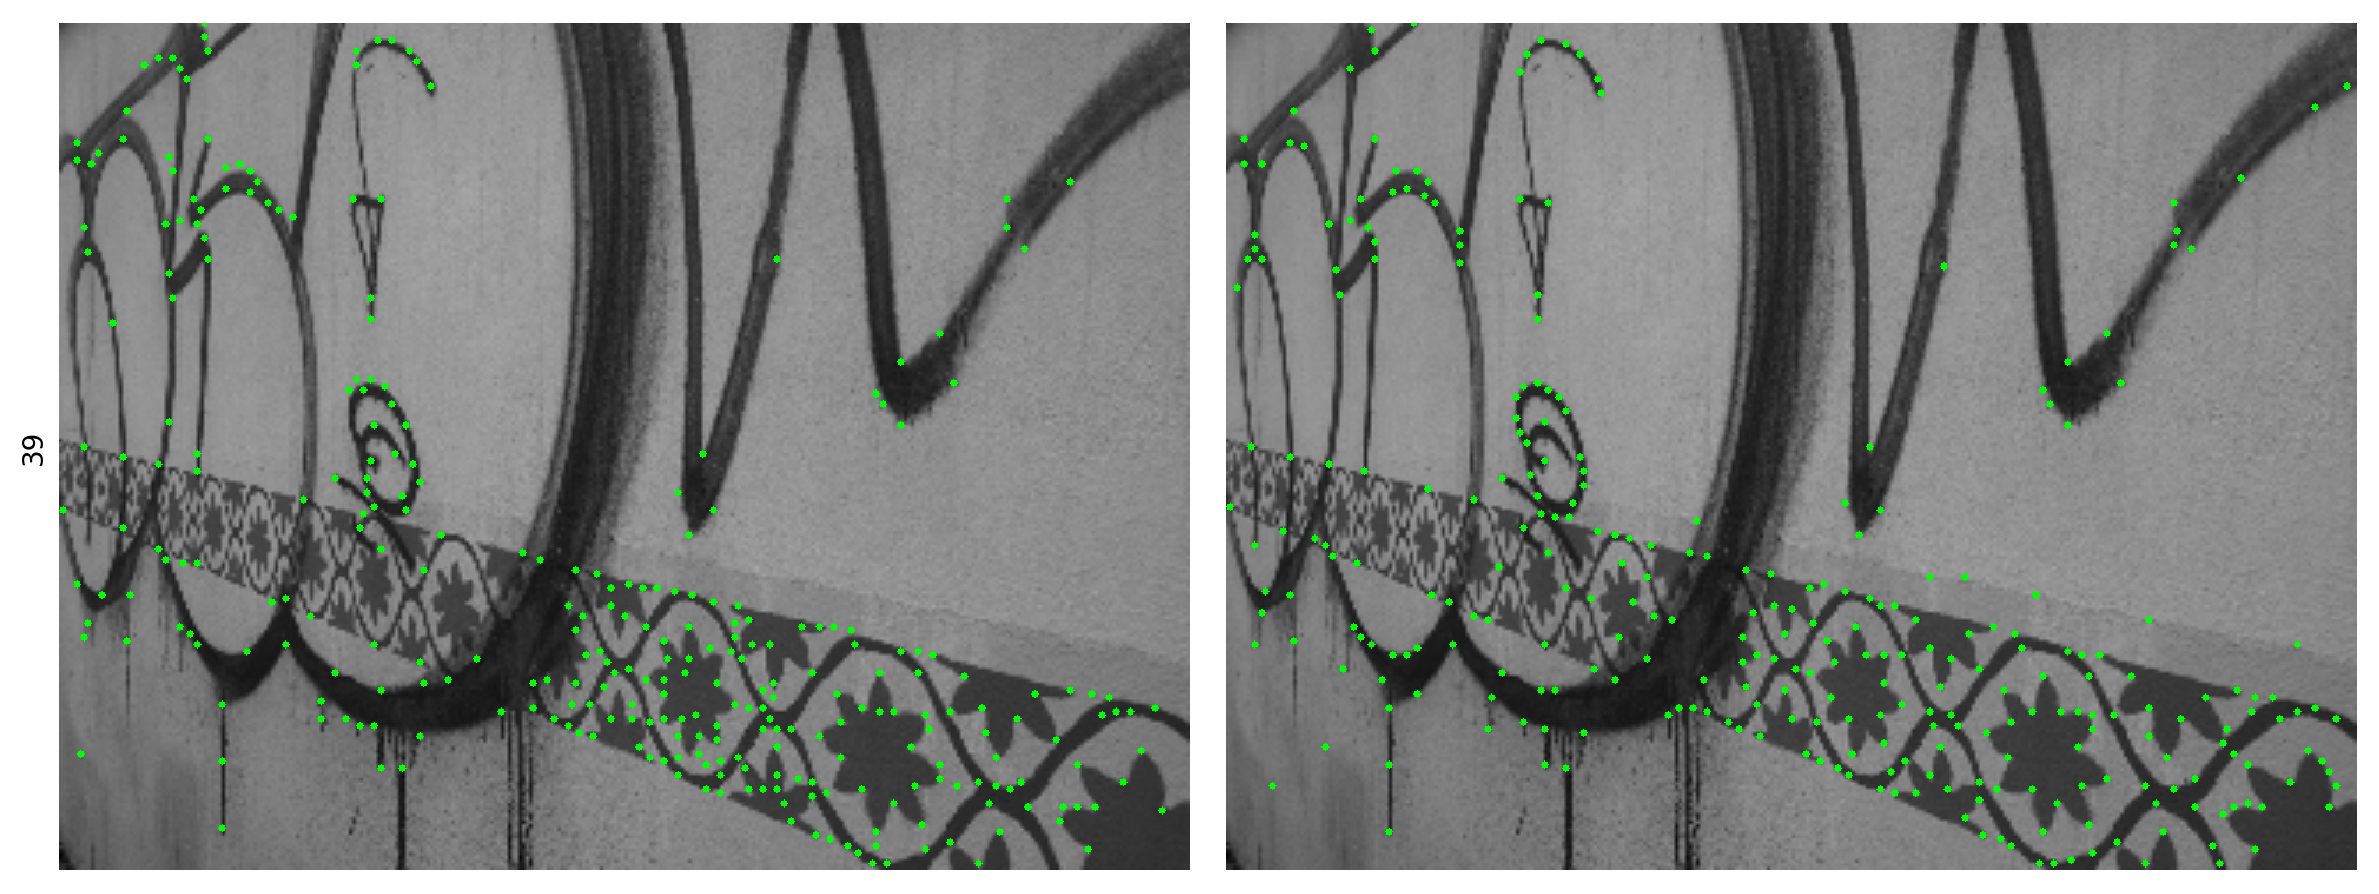

In [15]:
for i in [35, 36, 37, 38, 39]:
#for i in range(100):
    if (i % 5) == 0:
        ims = []
        for e in exp:
            path = Path(EXPER_PATH, "outputs", e, str(i) + ".npz")
            d = np.load(path)
            points1 = np.where(d['prob'] > thresh)
            idx = np.argsort(d['prob'][points1])[::-1][:num_points]
            points1 = (points1[0][idx], points1[1][idx])
            ims.append(draw_keypoints(d['image'], points1, (0, 255, 0)) / 255.)
        plot_imgs(ims, ylabel=i, titles=names, dpi=200, cmap='gray')
    
    ims = []
    for e in exp:
        path = Path(EXPER_PATH, "outputs", e, str(i) + ".npz")
        d = np.load(path)
        
        # Print repeatability and number of points
        print("> " + str(i) + ": rep = " + str(compute_repeatability(d, keep_k_points=300, distance_thresh=3, verbose=True)[2]))
        
        points1 = np.where(d['warped_prob'] > thresh)
        idx = np.argsort(d['warped_prob'][points1])[::-1][:num_points]
        points1 = (points1[0][idx], points1[1][idx])
        ims.append(draw_keypoints(d['warped_image'], points1, (0, 255, 0)) / 255.)
    
    plot_imgs(ims, ylabel=i, titles=names.append('original'), dpi=200, cmap='gray')